In [1]:
from pathlib import Path
import cfgrib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import datetime
import xarray as xr
from typing import Union

This notebook is research for [GitHub issue #344: Convert NWP grib files to Zarr intermediate](https://github.com/openclimatefix/nowcasting_dataset/issues/344).

Useful links:

* [Met Office's data docs](http://cedadocs.ceda.ac.uk/1334/1/uk_model_data_sheet_lores1.pdf)

Done:

* Merge Wholesale1 and 2 (2 includes dswrf, lcc, mcc, and hcc)
* Remove dimensions we don't care about (e.g. select temperature at 1 meter, not 0 meters)
* Reshape images from 1D to 2D.
* Do we really need to convert datetimes to unix epochs before appending to zarr?  If no, submit a bug report.

Some outstanding questions / Todo items

* eccodes takes ages to load multiple datasets from each grib.  Maybe it'd be faster to pre-load each grib into ramdisk?  
* Zarr chunk size and compression.
* Do we need to combine all the DataArrays into a single DataArray (with "variable" being a dimension?).  The upside is that then a single Zarr chunk can include multiple variables.  The downside is that we lose the metadata (but that's not a huge problem, maybe?)
* Reshaping is pretty slow.  Maybe go back to using `np.reshape`?
* Separately log "bad files" to a CSV file?
* Restart from last `time` in existing Zarr.
* Convert to float16?
* Check for NaNs.  cdcb has NaNs.
* Remove `wholesale_file_number`?
* Experiment with when it might be fastest to load data into memory.
* Parallelise
* Convert to script
* Use click to set source and target directories
* Fix this error (which occured whilst running on Leonardo): 

```
Loading /mnt/storage_b/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/NWP/UK_Met_Office/UKV/native/2016/03/24/201603241500_u1096_ng_umqv_Wholesale1.grib
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
Loading /mnt/storage_b/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/NWP/UK_Met_Office/UKV/native/2016/03/24/201603241500_u1096_ng_umqv_Wholesale2.grib
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
Merging...
Reshaping...
Writing to disk...
Traceback (most recent call last):
  File "/home/jack/dev/ocf/nowcasting_dataset/scripts/./convert_NWP_grib_to_zarr_draft.py", line 321, in <module>
    full_filenames = df.loc[nwp_init_datetime_utc].full_filename.values
AttributeError: 'PosixPath' object has no attribute 'values'
```

In [2]:
# Define geographical domain for UKV.
# Taken from page 4 of http://cedadocs.ceda.ac.uk/1334/1/uk_model_data_sheet_lores1.pdf
# To quote the PDF:
# "The United Kingdom domain is a 1,096km x 1,408km ~2km resolution grid.
# The OS National Grid corners of the domain are:"

DY_METERS = DX_METERS = 2_000
NORTH = 1223_000
SOUTH = -185_000
WEST = -239_000
EAST = 857_000

# Note that the UKV NWPs y is top-to-bottom
NORTHING = np.arange(start=NORTH, stop=SOUTH, step=-DY_METERS, dtype=np.int32)
EASTING = np.arange(start=WEST, stop=EAST, step=DX_METERS, dtype=np.int32)

NUM_ROWS = len(NORTHING)
NUM_COLS = len(EASTING)

In [3]:
# NWP_PATH = Path("/home/jack/Data/NWP/01")
NWP_PATH = Path("/media/jack/128GB_USB/NWPs")  # Must not include trailing slash!!!

In [4]:
filenames = list(NWP_PATH.glob("*/*/*/*Wholesale[12].grib"))

In [5]:
len(filenames)

76

In [6]:
def grib_filename_to_datetime_and_wholesale_file_number(full_filename: Path) -> dict[str, object]:
    """Parse the grib filename and return the datetime and wholesale number.
    
    Returns a dict with three keys: 'full_filename', `nwp_init_datetime_utc` and `wholesale_file_number`.
      For example, if the filename is '202101010000_u1096_ng_umqv_Wholesale1.grib',
      then `nwp_init_datetime_utc` will be datetime(year=2021, month=1, day=1, hour=0, minute=0)
      and the `wholesale_file_number` will be 1 (represented as an int).
      
    Raises RuntimeError if the filename does not match the expected regex pattern.
    """
    # Get the base_filename, which will be of the form '202101010000_u1096_ng_umqv_Wholesale1.grib'
    base_filename = full_filename.name

    # Use regex to match the year, month, day, hour, minute and wholesale_number.  i.e., group the filename like this:
    # '(2021)(01)(01)(00)(00)_u1096_ng_umqv_Wholesale(1)'.
    # A quick guide to the relevant regex operators:
    #   ^ matches the beginning of the string.
    #   () defines a group.
    #   (?P<name>...) names the group.  We can access the group with `regex_match.groupdict()[name]`.
    #   \d matches a single digit.
    #   {n} matches the preceding item n times.
    #   . matches any character.
    #   $ matches the end of the string.
    regex_pattern_string = (
        '^'  # Match the beginning of the string.
        '(?P<year>\d{4})'  # Match the year.
        '(?P<month>\d{2})'  # Match the month.
        '(?P<day>\d{2})'  # Match the day.
        '(?P<hour>\d{2})'  # Match the hour.
        '(?P<minute>\d{2})'  # Match the minute.
        '_u1096_ng_umqv_Wholesale'
        '(?P<wholesale_file_number>\d)'  # Match the number after "Wholesale".
        '\.grib$'  # Match the end of the string (escape the fullstop).
    )
    regex_pattern = re.compile(regex_pattern_string)
    regex_match = regex_pattern.match(base_filename)
    if regex_match is None:
        raise RuntimeError(f"Filename '{full_filename}' does not conform to expected regex pattern '{regex_pattern_string}'!")

    # Convert strings to ints:
    regex_groups = {key: int(value) for key, value in regex_match.groupdict().items()}

    wholesale_file_number = regex_groups.pop('wholesale_file_number')
    dt = datetime.datetime(**regex_groups)
    return {
        'full_filename': full_filename,
        'nwp_init_datetime_utc': dt,
        'wholesale_file_number': wholesale_file_number}

In [7]:
def decode_and_group_grib_filenames(filenames: list[Path]) -> pd.DataFrame:
    """Returns a DataFrame where the index is the datetime of the NWP init time.
    
    And the columns of the DataFrame are 'wholesale_file_number' and 'full_filename'.
    """
    n_filenames = len(filenames)
    df = pd.DataFrame(
        index=range(n_filenames), 
        columns=['full_filename', 'nwp_init_datetime_utc', 'wholesale_file_number'])
    for i, filename in enumerate(filenames):
        df.iloc[i] = grib_filename_to_datetime_and_wholesale_file_number(filename)
    
    # Change dtypes
    df = df.astype({'wholesale_file_number': np.int8})
    df['nwp_init_datetime_utc'] = pd.to_datetime(df['nwp_init_datetime_utc'])
    
    # Set index and sort
    df = df.set_index('nwp_init_datetime_utc')
    df = df.sort_index()
    return df

In [8]:
def load_grib_file(full_filename: Union[Path, str], verbose: bool=False) -> xr.Dataset:
    # The grib files are "heterogeneous", so we use cfgrib.open_datasets
    # to return a list of contiguous xr.Datasets.
    # See https://github.com/ecmwf/cfgrib#automatic-filtering
    datasets_from_grib = cfgrib.open_datasets(
        full_filename,
        backend_kwargs=dict(
            indexpath=''  # Disable GRIB index file.  See https://github.com/ecmwf/cfgrib#grib-index-file
        ),
    )

    # Get each dataset into the right shape for merging:
    n_datasets = len(datasets_from_grib)
    # Loop round the datasets using an index (instead of `for ds in datasets_from_grib`)
    # because we will be modifying each dataset:
    for i in range(n_datasets):
        ds = datasets_from_grib[i]
        
        if verbose:
            print("\nDataset", i, "before processing:\n", ds, "\n")
        
        ds = ds.drop_vars('valid_time')  # valid_time is easy to compute again later.
        if 't' in ds and 'heightAboveGround' in ds['t'].dims:
            # For temperature, we want the temperature at 1 meter above ground,
            # not at 0 meters above ground.  The early NWPs (definitely in the 2016-03-22 NWPs),
            # heightAboveGround only has 1 entry ("1") and isn't set as a dimension for ds['t'].
            # In later NWPs, 'heightAboveGround' is a dimension, and has 2 values (0, 1).
            ds = ds.sel(heightAboveGround=1)

            
        vars_to_delete = [
            'unknown', 'valid_time', 'heightAboveGround', 'heightAboveGroundLayer', 
            'atmosphere', 'cloudBase', 'surface', 'meanSea', 'level']
        for var_name in vars_to_delete:
            try:
                del ds[var_name]
            except KeyError as e:
                if verbose:
                    print('var name not in dataset:', e)
                
            else:
                if verbose:
                    print('Deleted', var_name)

        if verbose:
            print("\nDataset", i, "after processing:\n", ds, "\n")
            print("**************************************************")
            
        datasets_from_grib[i] = ds
        del ds
    
    return xr.merge(datasets_from_grib)

In [9]:
def reshape_1d_to_2d(dataset: xr.Dataset) -> xr.Dataset:
    """Convert 1D into 2D array.
    
    For each `step`, the pixel values in the grib files represent a 2D image.  But, in the grib,
    the values are in a flat 1D array (indexed by the `values` dimension).  The ordering of the pixels are row_0, row_1, row_2, etc.

    We reshape every data variable at once using this trick.
    """
    # Adapted from https://stackoverflow.com/a/62667154
    
    # Don't reshape yet.  Instead just create new coordinates,
    # which give the `x` and `y` position of each position in the `values` dimension:
    dataset = dataset.assign_coords(
        {
            'x': ('values', np.tile(EASTING, reps=NUM_ROWS)), 
            'y': ('values', np.repeat(NORTHING, repeats=NUM_COLS))
        })
    
    # Now set "values" to be a MultiIndex, indexed by `y` and `x`:
    dataset = dataset.set_index(values=("y", "x"))
    
    # Now unstack.  This gets rid of the `values` dimension and indexes
    # the data variables using `y` and `x`.
    return dataset.unstack("values")

In [10]:
def dataset_has_variables(dataset: xr.Dataset) -> bool:
    """Return True if `dataset` has at least one variable."""
    return len(dataset.variables) > 0

In [20]:
def append_to_zarr(dataset: xr.Dataset, zarr_path: Union[str, Path]):
    print("Writing to disk...")
    zarr_path = Path(zarr_path)
    if zarr_path.exists():
        to_zarr_kwargs = dict(
            append_dim = "time",
        )
    else:
        to_zarr_kwargs = dict(
            # Need to manually set the time units otherwise xarray defaults to using
            # units of *days* (and hence cannot represent sub-day temporal resolution), which corrupts
            # the `time` values when we appending to Zarr.  See:
            # https://github.com/pydata/xarray/issues/5969 and
            # http://xarray.pydata.org/en/stable/user-guide/io.html#time-units
            encoding={
                'time': {
                    'units': 'nanoseconds since 1970-01-01'
                },
            },
        )

    dataset.to_zarr(zarr_path, **to_zarr_kwargs)

In [12]:
def load_grib_for_single_nwp_init_time(full_filenames: list[Path]) -> xr.Dataset:
    datasets_for_nwp_init_datetime = []
    for full_filename in full_filenames:
        print('Loading', full_filename)
        try:
            dataset_for_filename = load_grib_file(full_filename)
        except EOFError as e:
            print(e, f"Filesize = {full_filename.stat().st_size:,d} bytes")
            # If any of the files associated with this nwp_init_datetime is broken then
            # skip all, because we don't want incomplete data for an init_datetime.
            datasets_for_nwp_init_datetime = []
            break
        else:
            if dataset_has_variables(dataset_for_filename):
                datasets_for_nwp_init_datetime.append(dataset_for_filename)
    if len(datasets_for_nwp_init_datetime) == 0:
        return
    print("Merging...")
    dataset_for_nwp_init_datetime = xr.merge(datasets_for_nwp_init_datetime)
    del datasets_for_nwp_init_datetime
    print("Reshaping...")
    dataset_for_nwp_init_datetime = reshape_1d_to_2d(dataset_for_nwp_init_datetime)
    return dataset_for_nwp_init_datetime.expand_dims("time", axis=0)

In [13]:
df = decode_and_group_grib_filenames(filenames)

In [15]:
for nwp_init_datetime_utc in df.index.unique():
    full_filenames = df.loc[nwp_init_datetime_utc]
    if len(full_filenames) != 2:
        print(len(full_filenames), "filenames found for", nwp_init_datetime_utc, ".  Expected 2. Skipping!")
        continue
    full_filenames = full_filenames.full_filename.values
    ds = load_grib_for_single_nwp_init_time(full_filenames)
    if ds is not None:
        append_to_zarr(ds, "/home/jack/data/nwp.zarr")

Loading /media/jack/128GB_USB/NWPs/2016/03/22/201603221500_u1096_ng_umqv_Wholesale1.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2016/03/22/201603221500_u1096_ng_umqv_Wholesale1.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2016/03/22/201603221800_u1096_ng_umqv_Wholesale1.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2016/03/22/201603221800_u1096_ng_umqv_Wholesale1.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2016/03/22/201603222100_u1096_ng_umqv_Wholesale2.grib


ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Loading /media/jack/128GB_USB/NWPs/2016/03/22/201603222100_u1096_ng_umqv_Wholesale1.grib


ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Merging...
Reshaping...
Writing to disk...
Loading /media/jack/128GB_USB/NWPs/2017/01/06/201701060000_u1096_ng_umqv_Wholesale1.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2017/01/06/201701060000_u1096_ng_umqv_Wholesale1.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2017/01/06/201701060300_u1096_ng_umqv_Wholesale2.grib


ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Loading /media/jack/128GB_USB/NWPs/2017/01/06/201701060300_u1096_ng_umqv_Wholesale1.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2017/01/06/201701060300_u1096_ng_umqv_Wholesale1.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2017/01/06/201701060600_u1096_ng_umqv_Wholesale2.grib


ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Loading /media/jack/128GB_USB/NWPs/2017/01/06/201701060600_u1096_ng_umqv_Wholesale1.grib


ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Merging...
Reshaping...
Writing to disk...
Loading /media/jack/128GB_USB/NWPs/2017/01/06/201701060900_u1096_ng_umqv_Wholesale2.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2017/01/06/201701060900_u1096_ng_umqv_Wholesale2.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2017/01/06/201701061200_u1096_ng_umqv_Wholesale2.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2017/01/06/201701061200_u1096_ng_umqv_Wholesale2.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2017/01/06/201701061500_u1096_ng_umqv_Wholesale1.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2017/01/06/201701061500_u1096_ng_umqv_Wholesale1.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2017/01/06/201701061800_u1096_ng_umqv_Wholesale1.grib


ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Loading /media/jack/128GB_USB/NWPs/2017/01/06/201701061800_u1096_ng_umqv_Wholesale2.grib


ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Merging...
Reshaping...
Writing to disk...
Loading /media/jack/128GB_USB/NWPs/2017/01/06/201701062100_u1096_ng_umqv_Wholesale1.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2017/01/06/201701062100_u1096_ng_umqv_Wholesale1.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2018/12/31/201812310000_u1096_ng_umqv_Wholesale1.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2018/12/31/201812310000_u1096_ng_umqv_Wholesale1.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2018/12/31/201812310300_u1096_ng_umqv_Wholesale1.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2018/12/31/201812310300_u1096_ng_umqv_Wholesale1.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2018/12/31/201812310600_u1096_ng_umqv_Wholesale2.grib


ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Loading /media/jack/128GB_USB/NWPs/2018/12/31/201812310600_u1096_ng_umqv_Wholesale1.grib


ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Merging...
Reshaping...
Writing to disk...
Loading /media/jack/128GB_USB/NWPs/2018/12/31/201812310900_u1096_ng_umqv_Wholesale1.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2018/12/31/201812310900_u1096_ng_umqv_Wholesale1.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2018/12/31/201812311200_u1096_ng_umqv_Wholesale2.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2018/12/31/201812311200_u1096_ng_umqv_Wholesale2.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2018/12/31/201812311500_u1096_ng_umqv_Wholesale1.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2018/12/31/201812311500_u1096_ng_umqv_Wholesale1.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2018/12/31/201812311800_u1096_ng_umqv_Wholesale2.grib


ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Loading /media/jack/128GB_USB/NWPs/2018/12/31/201812311800_u1096_ng_umqv_Wholesale1.grib


ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Merging...
Reshaping...
Writing to disk...
Loading /media/jack/128GB_USB/NWPs/2018/12/31/201812312100_u1096_ng_umqv_Wholesale2.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2018/12/31/201812312100_u1096_ng_umqv_Wholesale2.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2019/06/15/201906150000_u1096_ng_umqv_Wholesale1.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2019/06/15/201906150000_u1096_ng_umqv_Wholesale1.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2019/06/15/201906150300_u1096_ng_umqv_Wholesale1.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2019/06/15/201906150300_u1096_ng_umqv_Wholesale1.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2019/06/15/201906150600_u1096_ng_umqv_Wholesale2.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2019/06/15/201906150600_u1096_ng_umqv_Wholesale2.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2019/06/15/201906150900_u1096_

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Loading /media/jack/128GB_USB/NWPs/2019/06/15/201906150900_u1096_ng_umqv_Wholesale2.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2019/06/15/201906150900_u1096_ng_umqv_Wholesale2.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2019/06/15/201906151200_u1096_ng_umqv_Wholesale1.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2019/06/15/201906151200_u1096_ng_umqv_Wholesale1.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2019/06/15/201906151500_u1096_ng_umqv_Wholesale1.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2019/06/15/201906151500_u1096_ng_umqv_Wholesale1.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2019/06/15/201906151800_u1096_ng_umqv_Wholesale1.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2019/06/15/201906151800_u1096_ng_umqv_Wholesale1.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2019/06/15/201906152100_u1096_ng_umqv_Wholesale2.grib


ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Loading /media/jack/128GB_USB/NWPs/2019/06/15/201906152100_u1096_ng_umqv_Wholesale1.grib


ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Merging...
Reshaping...
Writing to disk...
Loading /media/jack/128GB_USB/NWPs/2020/01/01/202001010000_u1096_ng_umqv_Wholesale2.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2020/01/01/202001010000_u1096_ng_umqv_Wholesale2.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2020/01/01/202001010300_u1096_ng_umqv_Wholesale2.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2020/01/01/202001010300_u1096_ng_umqv_Wholesale2.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2020/01/01/202001010600_u1096_ng_umqv_Wholesale1.grib


ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Loading /media/jack/128GB_USB/NWPs/2020/01/01/202001010600_u1096_ng_umqv_Wholesale2.grib


ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Merging...
Reshaping...
Writing to disk...
Loading /media/jack/128GB_USB/NWPs/2020/01/01/202001010900_u1096_ng_umqv_Wholesale1.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2020/01/01/202001010900_u1096_ng_umqv_Wholesale1.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2020/01/01/202001011200_u1096_ng_umqv_Wholesale2.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2020/01/01/202001011200_u1096_ng_umqv_Wholesale2.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2020/01/01/202001011500_u1096_ng_umqv_Wholesale1.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2020/01/01/202001011500_u1096_ng_umqv_Wholesale1.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2020/01/01/202001011800_u1096_ng_umqv_Wholesale2.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2020/01/01/202001011800_u1096_ng_umqv_Wholesale2.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2020/01/01/202001012100_u1096_

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Loading /media/jack/128GB_USB/NWPs/2021/09/30/202109300000_u1096_ng_umqv_Wholesale1.grib


ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


Merging...
Reshaping...
Writing to disk...
Loading /media/jack/128GB_USB/NWPs/2021/09/30/202109300300_u1096_ng_umqv_Wholesale2.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2021/09/30/202109300300_u1096_ng_umqv_Wholesale2.grib' Filesize = 0 bytes
Loading /media/jack/128GB_USB/NWPs/2021/09/30/202109300600_u1096_ng_umqv_Wholesale1.grib
No valid message found in file: '/media/jack/128GB_USB/NWPs/2021/09/30/202109300600_u1096_ng_umqv_Wholesale1.grib' Filesize = 0 bytes
CPU times: user 3min 30s, sys: 22.9 s, total: 3min 53s
Wall time: 4min 23s


## Load from Zarr

In [16]:
ds_from_zarr = xr.open_dataset("/home/jack/data/nwp.zarr", engine="zarr")

In [17]:
ds_from_zarr

<xarray.Dataset>
Dimensions:  (time: 8, step: 37, y: 704, x: 548)
Coordinates:
  * step     (step) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 12:00:00
  * time     (time) datetime64[ns] 2016-03-22T21:00:00 ... 2021-09-30
  * x        (x) int64 -239000 -237000 -235000 -233000 ... 851000 853000 855000
  * y        (y) int64 -183000 -181000 -179000 ... 1219000 1221000 1223000
Data variables: (12/17)
    cdcb     (time, step, y, x) float32 ...
    dlwrf    (time, step, y, x) float32 ...
    dpt      (time, step, y, x) float32 ...
    dswrf    (time, step, y, x) float32 ...
    h        (time, step, y, x) float32 ...
    hcc      (time, step, y, x) float32 ...
    ...       ...
    r        (time, step, y, x) float32 ...
    sde      (time, step, y, x) float32 ...
    si10     (time, step, y, x) float32 ...
    t        (time, step, y, x) float32 ...
    vis      (time, step, y, x) float32 ...
    wdir10   (time, step, y, x) float32 ...
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_edition:            2
    GRIB_subCentre:          0
    institution:             U.K. Met Office - Exeter

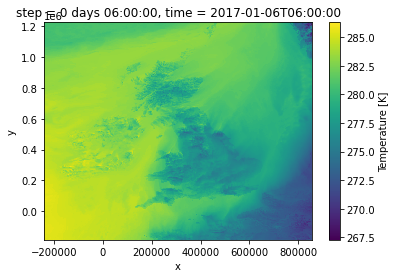

In [18]:
ds_from_zarr['t'].isel(step=6, time=1).plot.imshow()

In [22]:
ds_from_zarr['t'].encoding

{'chunks': (1, 10, 176, 137),
 'preferred_chunks': {'time': 1, 'step': 10, 'y': 176, 'x': 137},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float32')}

In [23]:
ds_from_zarr['t']

<xarray.DataArray 't' (time: 8, step: 37, y: 704, x: 548)>
array([[[[283.96002, ..., 280.26   ],
         ...,
         [282.26   , ..., 274.96002]],

        ...,

        [[284.005  , ..., 280.805  ],
         ...,
         [279.905  , ..., 273.305  ]]],


       ...,


       [[[290.97998, ..., 278.58   ],
         ...,
         [281.87997, ..., 283.37997]],

        ...,

        [[289.195  , ..., 290.695  ],
         ...,
         [283.495  , ..., 286.895  ]]]], dtype=float32)
Coordinates:
  * step     (step) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 12:00:00
  * time     (time) datetime64[ns] 2016-03-22T21:00:00 ... 2021-09-30
  * x        (x) int64 -239000 -237000 -235000 -233000 ... 851000 853000 855000
  * y        (y) int64 -183000 -181000 -179000 ... 1219000 1221000 1223000
Attributes:
    GRIB_NV:                         0
    GRIB_cfName:                     air_temperature
    GRIB_cfVarName:                  t
    GRIB_dataType:                   af
    GRIB_gridDefinitionDescription:  12
    GRIB_gridType:                   transverse_mercator
    GRIB_missingValue:               9999
    GRIB_name:                       Temperature
    GRIB_numberOfPoints:             385792
    GRIB_paramId:                    130
    GRIB_shortName:                  t
    GRIB_stepType:                   instant
    GRIB_stepUnits:                  1
    GRIB_typeOfLevel:                heightAboveGround
    GRIB_units:                      K
    coordinates:                     time step heightAboveGround valid_time
    long_name:                       Temperature
    standard_name:                   air_temperature
    units:                           K